In [2]:
## Question - 1
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from torchvision import datasets

np.random.seed(66)

mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)

def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
        descriptors = descriptors.astype(np.float32)
    return keypoints, descriptors

train_descriptors = []
train_labels = []

for image, label in mnist_train:
    keypoints, descriptors = extract_sift_features(np.array(image))
    if descriptors is not None:
        train_descriptors.extend(descriptors)
        train_labels.extend([label] * len(descriptors))

kmeans = KMeans(n_clusters=100)
kmeans.fit(np.array(train_descriptors, dtype=np.float32))
visual_words = kmeans.cluster_centers_.astype(np.float32)

def image_to_histogram(image, visual_words, kmeans):
    keypoints, descriptors = extract_sift_features(image)
    if descriptors is not None:
        histogram = np.zeros(len(visual_words), dtype=np.float32) 
        labels = kmeans.predict(descriptors.astype(np.float32))
        for label in labels:
            histogram[label] += 1
        return histogram / np.sum(histogram)
    else:
        return np.zeros(len(visual_words), dtype=np.float32)

train_histograms = []
train_labels = []

for image, label in mnist_train:
    histogram = image_to_histogram(np.array(image), visual_words, kmeans)
    train_histograms.append(histogram)
    train_labels.append(label)

svm_model = SVC(kernel='linear')
svm_model.fit(train_histograms, train_labels)

test_histograms = []
test_labels = []

for image, label in mnist_test:
    histogram = image_to_histogram(np.array(image), visual_words, kmeans)
    test_histograms.append(histogram)
    test_labels.append(label)

predictions = svm_model.predict(test_histograms)
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7437


Number of clusters: 5
Number of clusters: 10
Number of clusters: 20
Number of clusters: 50
Number of clusters: 100
Number of clusters: 200


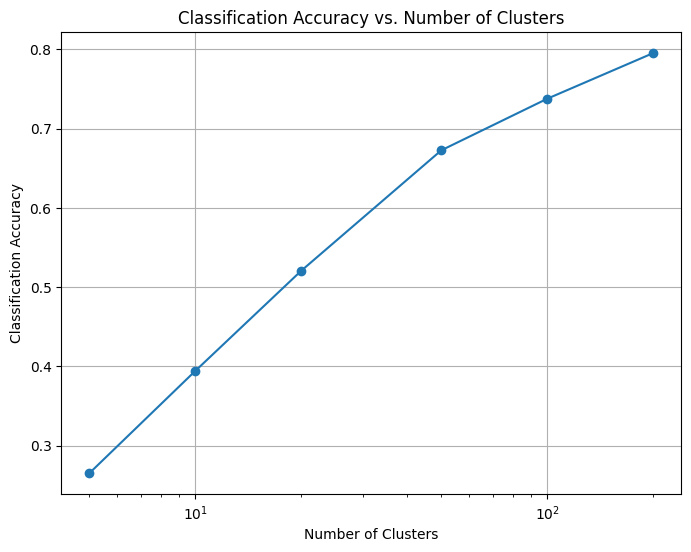

In [3]:
import matplotlib.pyplot as plt

cluster_counts = [5, 10, 20, 50, 100, 200]
accuracies = []

for clusters in cluster_counts:
    print(f'Number of clusters: {clusters}')
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(np.array(train_descriptors, dtype=np.float32))
    visual_words = kmeans.cluster_centers_.astype(np.float32)
    train_histograms = []
    for image, label in mnist_train:
        histogram = image_to_histogram(np.array(image), visual_words, kmeans)
        train_histograms.append(histogram)

    svm_model = SVC(kernel='linear')
    svm_model.fit(train_histograms, train_labels)
    test_histograms = []
    for image, label in mnist_test:
        histogram = image_to_histogram(np.array(image), visual_words, kmeans)
        test_histograms.append(histogram)

    predictions = svm_model.predict(test_histograms)
    accuracy = accuracy_score(test_labels, predictions)
    accuracies.append(accuracy)
    print(f'Accuracy: {accuracy}')

plt.figure(figsize=(8, 6))
plt.plot(cluster_counts, accuracies, marker='o')
plt.xscale('log')
plt.xlabel('Number of Clusters')
plt.ylabel('Classification Accuracy')
plt.title('Classification Accuracy vs. Number of Clusters')
plt.grid(True)
plt.show()

In [4]:
from sklearn.svm import LinearSVC

# Define the hyperparameter settings
hyperparams = [
    {'detector': 'SIFT', 'descriptor': 'SIFT', 'C': 1.0},
    {'detector': 'SIFT', 'descriptor': 'SIFT', 'C': 0.1},
    {'detector': 'SIFT', 'descriptor': 'SIFT', 'C': 10.0},
    {'detector': 'ORB', 'descriptor': 'ORB', 'C': 1.0},
    {'detector': 'SURF', 'descriptor': 'SURF', 'C': 1.0},
    {'detector': 'SURF', 'descriptor': 'SURF', 'C': 0.1}
]

def extract_features(image, detector_type, descriptor_type):
    if detector_type == 'SIFT':
        detector = cv2.SIFT_create()
    elif detector_type == 'ORB':
        detector = cv2.ORB_create()
    elif detector_type == 'SURF':
        detector = cv2.xfeatures2d.SURF_create()
    else:
        raise ValueError("Invalid detector type")

    keypoints, descriptors = detector.detectAndCompute(image, None)

    return keypoints, descriptors
# List to store accuracy for each hyperparameter setting
accuracies = []

for params in hyperparams:
    # Step 2: Extract keypoints and descriptors based on hyperparameters
    train_descriptors = []
    train_labels = []
    for image, label in mnist_train:
        keypoints, descriptors = extract_features(np.array(image), params['detector'], params['descriptor'])
        if descriptors is not None:
            train_descriptors.extend(descriptors)
            train_labels.extend([label] * len(descriptors))
    
    # Ensure consistency in the number of samples
    assert len(train_descriptors) == len(train_labels), "Number of descriptors and labels should be the same"

    # Step 3: Cluster descriptors to obtain visual word vocabulary
    kmeans = KMeans(n_clusters=100)
    kmeans.fit(np.array(train_descriptors, dtype=np.float32))
    visual_words = kmeans.cluster_centers_.astype(np.float32)

    # Print the number of images in the training dataset
    print("Number of images in the training dataset:", len(mnist_train))

    # Step 4: Represent images as histograms of visual words
    train_histograms = []
    train_labels = []
    failed_labels = []
    for image, label in mnist_train:
        histogram = image_to_histogram(np.array(image), visual_words, kmeans)
        if histogram is not None:
            train_histograms.append(histogram)
            train_labels.append(label)  # Append label only once for each image
        else:
            failed_labels.append(label)
            print(f"Warning: Histogram computation failed for image with label {label}")

    # Print the number of histograms and failed labels
    print("Number of histograms:", len(train_histograms))
    print("Number of failed labels:", len(failed_labels))
    print("Failed labels:", failed_labels)

    # Ensure consistency in the number of samples
    assert len(train_histograms) == len(train_labels), f"Number of histograms ({len(train_histograms)}) and labels ({len(train_labels)}) should be the same."

    # Step 5: Train a linear SVM model for classification based on hyperparameters
    svm_model = LinearSVC(C=params['C'], max_iter=10000)
    svm_model.fit(train_histograms, train_labels)

    # Step 6: Evaluate model performance on the test set
    test_histograms = []
    for image, label in mnist_test:
        histogram = image_to_histogram(np.array(image), visual_words, kmeans)
        test_histograms.append(histogram)

    predictions = svm_model.predict(test_histograms)
    accuracy = accuracy_score(test_labels, predictions)
    accuracies.append(accuracy)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(hyperparams) + 1), accuracies, marker='o')
plt.xticks(range(1, len(hyperparams) + 1), [f'{params["detector"]} - {params["descriptor"]} - C={params["C"]}' for params in hyperparams], rotation=45)
plt.xlabel('Hyperparameter Setting')
plt.ylabel('Classification Accuracy')
plt.title('Classification Accuracy for Different Hyperparameter Settings')
plt.grid(True)
plt.tight_layout()
plt.show()

Number of images in the training dataset: 60000
Number of histograms: 60000
Number of failed labels: 0
Failed labels: []


c:\Users\saipr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Number of images in the training dataset: 60000
Number of histograms: 60000
Number of failed labels: 0
Failed labels: []


c:\Users\saipr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Number of images in the training dataset: 60000
Number of histograms: 60000
Number of failed labels: 0
Failed labels: []


c:\Users\saipr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Epoch 1/10, Train Loss: 0.2704, Train Acc: 0.9185, Val Loss: 0.1076, Val Acc: 0.9667
Epoch 2/10, Train Loss: 0.0850, Train Acc: 0.9737, Val Loss: 0.0755, Val Acc: 0.9766
Epoch 3/10, Train Loss: 0.0610, Train Acc: 0.9808, Val Loss: 0.0613, Val Acc: 0.9808
Epoch 4/10, Train Loss: 0.0463, Train Acc: 0.9854, Val Loss: 0.0536, Val Acc: 0.9837
Epoch 5/10, Train Loss: 0.0390, Train Acc: 0.9871, Val Loss: 0.0509, Val Acc: 0.9843
Epoch 6/10, Train Loss: 0.0300, Train Acc: 0.9901, Val Loss: 0.0480, Val Acc: 0.9856
Epoch 7/10, Train Loss: 0.0271, Train Acc: 0.9913, Val Loss: 0.0486, Val Acc: 0.9857
Epoch 8/10, Train Loss: 0.0235, Train Acc: 0.9922, Val Loss: 0.0507, Val Acc: 0.9863
Epoch 9/10, Train Loss: 0.0212, Train Acc: 0.9931, Val Loss: 0.0553, Val Acc: 0.9851
Epoch 10/10, Train Loss: 0.0195, Train Acc: 0.9932, Val Loss: 0.0429, Val Acc: 0.9890


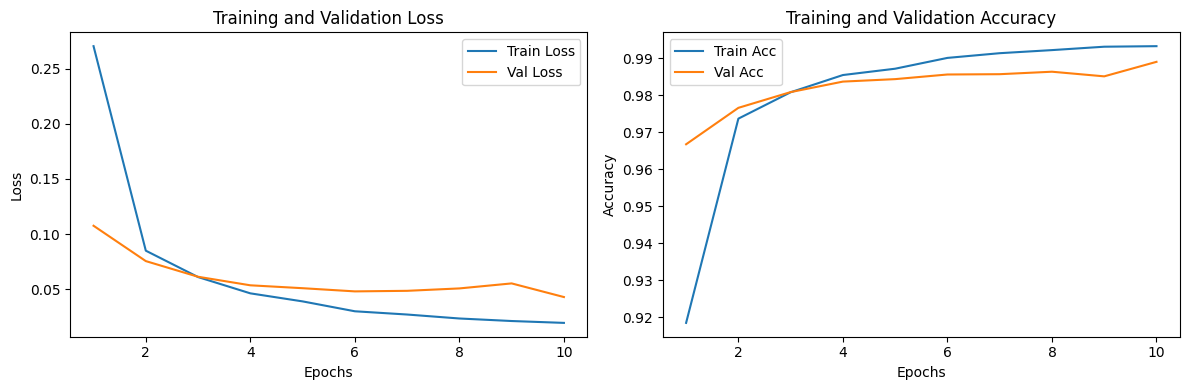

Test Loss: 0.0369, Test Acc: 0.9899


In [16]:
## Question - 2

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(66)

def load_mnist_dataset(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def eval_epoch(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(data_loader.dataset)
    accuracy = correct / total

    return loss, accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    model.to(device)
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        if val_loader is not None:
            val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)
    
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Acc')
    plt.plot(epochs, val_accuracies, label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    return test_loss, test_acc  
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
num_epochs = 10
learning_rate = 0.001

# Load dataset
train_loader, val_loader, test_loader = load_mnist_dataset(batch_size)

# Initialize model, loss function, and optimizer
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

# Test the model
test_loss, test_acc = test_model(model, test_loader, criterion, device)

In [12]:
hyperparameters = [
    {"batch_size": 64, "learning_rate": 0.001, "optimizer": "Adam"},
    {"batch_size": 128, "learning_rate": 0.001, "optimizer": "Adam"},
    {"batch_size": 64, "learning_rate": 0.01, "optimizer": "Adam"},
    {"batch_size": 64, "learning_rate": 0.001, "optimizer": "SGD"},
    {"batch_size": 64, "learning_rate": 0.001, "optimizer": "RMSprop"},
    {"batch_size": 64, "learning_rate": 0.001, "optimizer": "Adagrad"},
]

# Define number of epochs
num_epochs = 10

# Load datasets
_, _, test_loader = load_mnist_dataset()

# Experiment with different hyperparameter settings
for i, params in enumerate(hyperparameters):
    print(f"Experiment {i+1}/{len(hyperparameters)}")
    print(f"Hyperparameters: {params}")

    # Load datasets with specified batch size
    train_loader, _, _ = load_mnist_dataset(batch_size=params["batch_size"])

    # Initialize the model
    model = LeNet()

    # Define loss function and optimizer based on hyperparameters
    criterion = nn.CrossEntropyLoss()
    if params["optimizer"] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])
    elif params["optimizer"] == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=params["learning_rate"])
    elif params["optimizer"] == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=params["learning_rate"])
    elif params["optimizer"] == "Adagrad":
        optimizer = optim.Adagrad(model.parameters(), lr=params["learning_rate"])
    else:
        raise ValueError("Invalid optimizer specified")

    # Train the model (passing an empty validation data loader)
    train_losses, train_accuracies, _, _ = train_model(model, train_loader, torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.zeros(1), torch.zeros(1))), criterion, optimizer, num_epochs, device="cpu")

    # Test the model
    test_loss, test_acc = test_model(model, test_loader, criterion, device="cpu")
    print(f"Test Accuracy: {test_acc:.4f}")
    print()

Experiment 1/6
Hyperparameters: {'batch_size': 64, 'learning_rate': 0.001, 'optimizer': 'Adam'}


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1]